# Generate Parameter Screen

Author: Jacob Parres-Gold (jacobparresgold@gmail.com)

Last Revised: 20231019

This notebook analyzes the Boolean complexity of the two-, three-, and four-input logic gates analyzed in this work.

In [1]:
import eqtk
import itertools
import math
import numpy as np
import pathlib
import sys

# Boolean logic
import sympy

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker

In [2]:
# Load utility functions from dimer_network_utilities.py
utilities_path = str(pathlib.Path('C:\\Users','jacob','Local_Coding',\
                                  'ElowitzLab','Promiscuous_Networks','Notebooks','Paper_Notebooks')) # Directory of your utilities.py file
sys.path.append(utilities_path)
from dimer_network_utilities import *

In [3]:
# Define directory of the archived data folder parresgold_2023_dimer_networks_data
load_dir = str(pathlib.Path('C:\\Users','jacob','OneDrive - California Institute of Technology','Data','Dimer Networks','parresgold_2023_dimer_networks_data'))

In [4]:
specific_load_dir = str(pathlib.Path(load_dir,'optimization_trials_high_dim_logic_gates'))

In [5]:
out_dir = str(pathlib.Path('C:\\Users','jacob','Downloads'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [6]:
# Plotting settings
rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],	
    "font.size":9,
    "axes.titlesize":9,
    "axes.labelsize":9,
    "xtick.labelsize":9,
    "ytick.labelsize":9,
    "savefig.dpi": 900, 
    'figure.figsize': [6.0, 4.0],
    'figure.dpi': 150,
    'pdf.fonttype':42,
    'ps.fonttype':42,
})

In [7]:
# Print package versions
import pkg_resources
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print("Package versions:")
print("python={}".format(sys.version.split('|')[0].replace(' ','')))
for r in requirements:
    print("{}={}".format(*r))

Package versions:
python=3.8.13
eqtk=0.1.3
matplotlib=3.7.1
networkx=2.7.1
numpy=1.21.5
pandas=1.4.1
scipy=1.10.1


Create global lists and complexity-quantifying function

In [8]:
required_m_by_gate_all = []
num_ANDOR_gates_all = []

In [9]:
def count_gates(expression):
    gate_count = {
        "AND": 0,
        "OR": 0,
        "NOT": 0,
    }
    # Count how many gates are in the highest-level expression
    gate_count[str(expression.func).upper()] += int(len(expression.args)-1)

    # For each term within this expression, recursively analyze
    for term in expression.args:
        # Skip if at the lowest level
        if type(term)==sympy.core.symbol.Symbol:
            continue
        gate_count[str(term.func).upper()] += count_gates(term)[str(term.func).upper()]

    return gate_count

## 2-Input Functions

In [10]:
num_inputs = 2

In [11]:
m_list = list(range(2,7))

### Create Objectives

This code is from previous notebooks, generates all logic gates as a `numpy` array:

In [12]:
input_combos = list(itertools.product(range(2),repeat=num_inputs))
num_input_combos = len(input_combos)

# Identify symmetric input combinations
symmetric_input_combos = [[i for i,x in enumerate(input_combos) if np.sum(x)==num_inputs_on] for num_inputs_on in range(num_inputs+1)]

possible_outputs = [0,1] # possible values output(s) may take on. If >1 output, use similar code as for input_combos
objective_gates = np.array(list(itertools.product(possible_outputs,repeat=num_input_combos)))

# Remove trivial gates (always off or on)
objective_gates = np.array([gate for gate in objective_gates if not len(set(gate))==1])

# # Remove trivial gates (an input doesn't affect the output)
for input_ in range(num_inputs):
    input_off = np.array([i for i,x in enumerate(input_combos) if x[input_]==0])
    input_on = np.array([i for i,x in enumerate(input_combos) if x[input_]==1])
    objective_gates2 = []
    for gate in objective_gates:
        if not np.all([gate[off_case]==gate[on_case] for off_case,on_case in zip(input_off,input_on)]):
            objective_gates2.append(gate)
    objective_gates = np.array(objective_gates2)

# Removal symmetric gates (identical upon input permutation)
for symmetric_input_combo in symmetric_input_combos:
    objective_gates = np.array([gate for gate in objective_gates if np.all(gate[symmetric_input_combo]==np.sort(gate[symmetric_input_combo]))])

Let's try converting these to `sympy` notation:

In [13]:
A, B = sympy.symbols('A B')

In [14]:
overall_logic_expressions = []

# Output sequence
for function_of_interest in objective_gates:
    overall_logic_expression = None
    # Input combinations
    for input_combo_i, input_combo in enumerate(input_combos):
        input_symbols = [A if input_combo[0] else sympy.Not(A),\
                                B if input_combo[1] else sympy.Not(B)]
        
        output = function_of_interest[input_combo_i]

        if output:
            symbol_term = (sympy.And(*input_symbols))

            if overall_logic_expression is None:
                overall_logic_expression = symbol_term
            else:
                overall_logic_expression = sympy.Or(overall_logic_expression, symbol_term)
    
    overall_logic_expressions.append(overall_logic_expression)


In [15]:
simplified_logic_expressions = []

# Simplify to DNF or CNF forms, whichever has fewest terms
for overall_logic_expression in overall_logic_expressions:
    simplified_logic_expressions.append(sympy.logic.boolalg.simplify_logic(overall_logic_expression))

In [16]:
num_ANDOR_gates_2input = []

for expression_i in range(len(overall_logic_expressions)):
    counted_gates = count_gates(simplified_logic_expressions[expression_i])
    num_ANDOR_gates_2input.append(counted_gates['AND']+counted_gates['OR'])

In [17]:
required_m_by_gate_2input = [
    2, # AND
    3, # NIMPLY - assuming non-sharp transition
    6, # XOR
    4, # OR
    3, # NOR
    5, # XNOR
    4, # IMPLY - assuming non-sharp transition
   4 , # NAND
]

In [18]:
required_m_by_gate_all+=list(required_m_by_gate_2input)
num_ANDOR_gates_all+=list(num_ANDOR_gates_2input)

## 3-Input Functions

In [19]:
num_inputs =3

In [20]:
successful_3D_gates_by_m = np.load(str(pathlib.Path(specific_load_dir,f'{num_inputs}input_successful_gates_by_m.npy')),allow_pickle=True).tolist()

In [21]:
m_list = list(successful_3D_gates_by_m.keys())

### Create Objectives

This code is from previous notebooks, generates all logic gates as a `numpy` array:

In [22]:
input_combos = list(itertools.product(range(2),repeat=num_inputs))
num_input_combos = len(input_combos)

# Identify symmetric input combinations
symmetric_input_combos = [[i for i,x in enumerate(input_combos) if np.sum(x)==num_inputs_on] for num_inputs_on in range(num_inputs+1)]

possible_outputs = [0,1] # possible values output(s) may take on. If >1 output, use similar code as for input_combos
objective_gates = np.array(list(itertools.product(possible_outputs,repeat=num_input_combos)))

# Remove trivial gates (always off or on)
objective_gates = np.array([gate for gate in objective_gates if not len(set(gate))==1])

# # Remove trivial gates (an input doesn't affect the output)
for input_ in range(num_inputs):
    input_off = np.array([i for i,x in enumerate(input_combos) if x[input_]==0])
    input_on = np.array([i for i,x in enumerate(input_combos) if x[input_]==1])
    objective_gates2 = []
    for gate in objective_gates:
        if not np.all([gate[off_case]==gate[on_case] for off_case,on_case in zip(input_off,input_on)]):
            objective_gates2.append(gate)
    objective_gates = np.array(objective_gates2)

# Removal symmetric gates (identical upon input permutation)
for symmetric_input_combo in symmetric_input_combos:
    objective_gates = np.array([gate for gate in objective_gates if np.all(gate[symmetric_input_combo]==np.sort(gate[symmetric_input_combo]))])

Let's try converting these to `sympy` notation:

In [23]:
A, B, C = sympy.symbols('A B C')

In [24]:
overall_logic_expressions = []

# Output sequence
for function_of_interest in objective_gates:
    overall_logic_expression = None
    # Input combinations
    for input_combo_i, input_combo in enumerate(input_combos):
        input_symbols = [A if input_combo[0] else sympy.Not(A),\
                                B if input_combo[1] else sympy.Not(B), \
                                    C if input_combo[2] else sympy.Not(C)]
        
        output = function_of_interest[input_combo_i]

        if output:
            symbol_term = (sympy.And(*input_symbols))

            if overall_logic_expression is None:
                overall_logic_expression = symbol_term
            else:
                overall_logic_expression = sympy.Or(overall_logic_expression, symbol_term)
    
    overall_logic_expressions.append(overall_logic_expression)


In [25]:
simplified_logic_expressions = []

# Simplify to DNF or CNF forms, whichever has fewest terms
for overall_logic_expression in overall_logic_expressions:
    simplified_logic_expressions.append(sympy.logic.boolalg.simplify_logic(overall_logic_expression))

In [26]:
num_ANDOR_gates_3input = []

for expression_i in range(len(overall_logic_expressions)):
    counted_gates = count_gates(simplified_logic_expressions[expression_i])
    num_ANDOR_gates_3input.append(counted_gates['AND']+counted_gates['OR'])

In [27]:
successful_3D_gates_by_m = np.load(str(pathlib.Path(specific_load_dir,f'{num_inputs}input_successful_gates_by_m.npy')),allow_pickle=True).tolist()

required_m_by_gate_3input = np.zeros(len(objective_gates))
for m in m_list:
    for gate_i in successful_3D_gates_by_m[m]:
        required_m_by_gate_3input[gate_i] = m

In [28]:
required_m_by_gate_all+=list(required_m_by_gate_3input)
num_ANDOR_gates_all+=list(num_ANDOR_gates_3input)

## 4-Input Functions

In [29]:
num_inputs =4

In [30]:
successful_4D_gates_by_m = np.load(str(pathlib.Path(specific_load_dir,f'{num_inputs}input_successful_gates_by_m.npy')),allow_pickle=True).tolist()

In [31]:
m_list = list(successful_4D_gates_by_m.keys())

### Create Objectives

This code is from previous notebooks, generates all logic gates as a `numpy` array:

For the purposes of higher dimensions, we will choose just a few types of gates to investigate

In [32]:
input_combos = list(itertools.product(range(2),repeat=num_inputs))
num_input_combos = len(input_combos)
objective_gates = []

# AT LEAST and AND
for at_least in range(1,num_inputs+1):
    objective_gates.append([1 if np.where(input_combo)[0].shape[0]>=at_least else 0 for input_combo in input_combos])

objective_gates = np.array(objective_gates)

Let's try converting these to `sympy` notation:

In [33]:
A, B, C, D = sympy.symbols('A B C D')

In [34]:
overall_logic_expressions = []

# Output sequence
for function_of_interest in objective_gates:
    overall_logic_expression = None
    # Input combinations
    for input_combo_i, input_combo in enumerate(input_combos):
        input_symbols = [A if input_combo[0] else sympy.Not(A),\
                                B if input_combo[1] else sympy.Not(B), \
                                C if input_combo[2] else sympy.Not(C),\
                                D if input_combo[3] else sympy.Not(D),\
                        ]
        
        output = function_of_interest[input_combo_i]

        if output:
            symbol_term = (sympy.And(*input_symbols))

            if overall_logic_expression is None:
                overall_logic_expression = symbol_term
            else:
                overall_logic_expression = sympy.Or(overall_logic_expression, symbol_term)
    
    overall_logic_expressions.append(overall_logic_expression)


In [35]:
simplified_logic_expressions = []

# Simplify to DNF or CNF forms, whichever has fewest terms
for overall_logic_expression in overall_logic_expressions:
    simplified_logic_expressions.append(sympy.logic.boolalg.simplify_logic(overall_logic_expression))

In [36]:
num_ANDOR_gates_4input = []

for expression_i in range(len(overall_logic_expressions)):
    counted_gates = count_gates(simplified_logic_expressions[expression_i])
    num_ANDOR_gates_4input.append(counted_gates['AND']+counted_gates['OR'])

In [37]:
required_m_by_gate_4input = np.zeros(len(objective_gates))
for m in m_list:
    for gate_i in successful_4D_gates_by_m[m]:
        required_m_by_gate_4input[gate_i] = m

In [38]:
required_m_by_gate_all+=list(required_m_by_gate_4input)
num_ANDOR_gates_all+=list(num_ANDOR_gates_4input)

## Save

In [39]:
np.save(str(pathlib.Path(out_dir,'required_m_by_gate_2input.npy')),required_m_by_gate_2input)
np.save(str(pathlib.Path(out_dir,'num_ANDOR_gates_2input.npy')),num_ANDOR_gates_2input)

np.save(str(pathlib.Path(out_dir,'required_m_by_gate_3input.npy')),required_m_by_gate_3input)
np.save(str(pathlib.Path(out_dir,'num_ANDOR_gates_3input.npy')),num_ANDOR_gates_3input)

np.save(str(pathlib.Path(out_dir,'required_m_by_gate_4input.npy')),required_m_by_gate_4input)
np.save(str(pathlib.Path(out_dir,'num_ANDOR_gates_4input.npy')),num_ANDOR_gates_4input)

np.save(str(pathlib.Path(out_dir,'required_m_by_gate_all.npy')),required_m_by_gate_all)
np.save(str(pathlib.Path(out_dir,'num_ANDOR_gates_all.npy')),num_ANDOR_gates_all)

## Plot Boolean complexity vs. monomers required

### Load

In [40]:
required_m_by_gate_2input = np.load(str(pathlib.Path(out_dir,'required_m_by_gate_2input.npy')))
num_ANDOR_gates_2input = np.load(str(pathlib.Path(out_dir,'num_ANDOR_gates_2input.npy')))

required_m_by_gate_3input = np.load(str(pathlib.Path(out_dir,'required_m_by_gate_3input.npy')))
num_ANDOR_gates_3input = np.load(str(pathlib.Path(out_dir,'num_ANDOR_gates_3input.npy')))

required_m_by_gate_4input = np.load(str(pathlib.Path(out_dir,'required_m_by_gate_4input.npy')))
num_ANDOR_gates_4input = np.load(str(pathlib.Path(out_dir,'num_ANDOR_gates_4input.npy')))

required_m_by_gate_all = np.load(str(pathlib.Path(out_dir,'required_m_by_gate_all.npy')))
num_ANDOR_gates_all = np.load(str(pathlib.Path(out_dir,'num_ANDOR_gates_all.npy')))

In [ ]:
triple_colors = [
        (171,108,0), # Brown
        (64,176,166), # Teal
        (122, 68, 194), # Purple
]

triple_colors = [tuple([x/255 for x in color]) for color in triple_colors]

cmap = mcolors.ListedColormap(triple_colors)

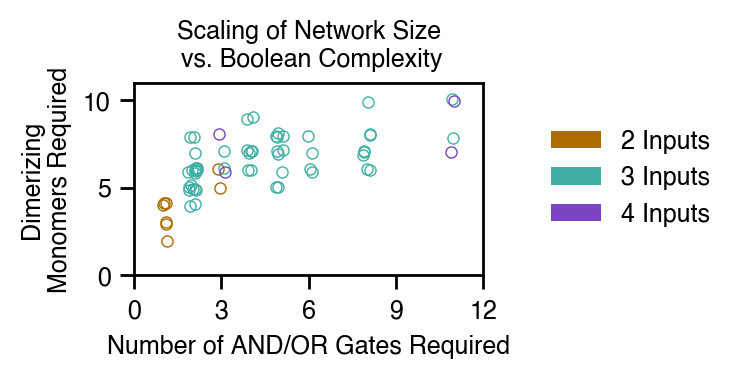

In [ ]:
save = True

fig, ax = plt.subplots(figsize=(2.25,1.25))

# Add jitter
rng = np.random.default_rng(41)
halfrange = 0.15
num_ANDOR_gates_byinput = [
    num_ANDOR_gates_2input,
    num_ANDOR_gates_3input,
    num_ANDOR_gates_4input,
]
required_m_by_gate_byinput = [
    required_m_by_gate_2input,
    required_m_by_gate_3input,
    required_m_by_gate_4input,
]
for i, num_inputs in enumerate(range(2,5)):
    ax.plot(np.array(num_ANDOR_gates_byinput[i])+rng.uniform(-halfrange,halfrange,size=len(num_ANDOR_gates_byinput[i])),\
            np.array(required_m_by_gate_byinput[i])+rng.uniform(-halfrange,halfrange,size=len(num_ANDOR_gates_byinput[i])),\
            marker='.',markersize=8,markerfacecolor='none',markeredgecolor=cmap(i),linestyle='',alpha=1,markeredgewidth=0.5)

ax.set_xlim([0,np.max(num_ANDOR_gates_all)+1])
ax.set_xticks(np.linspace(0,np.max(num_ANDOR_gates_all)+1,5))
ax.set_ylim([0,11])

_ = ax.set_xlabel('Number of AND/OR Gates Required')
_ = ax.set_ylabel('Required\nNetwork Size')
_ = ax.set_title('Scaling of Network Size\n vs. Boolean Complexity')

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

fig.set_dpi(200)

patches={}
for i, num_inputs in enumerate(range(2,5)):
    patches[i] = mpatches.Patch(facecolor=cmap(i),linewidth=0,linestyle='',\
                                                alpha=1,label=f'{num_inputs} Inputs',\
                                                edgecolor=None)

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

if save:
    filename = f'monomers_required_vs_boolean_complexity_byinputs'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')